In [2]:
import os
import librosa
import librosa.display
import soundfile as sf
import IPython.display as ipd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from module.sound import get_auduo_jump_power
import re

import importlib
#importlib.reload(module.sound)
# %load_ext autoreload
# %autoreload 2


C:\Users\Nikolas\AppData\Local\Temp\ipykernel_24764\1977282727.py:7: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [5]:
folder_path = 'raw_data'
folder_lim_path = 'raw_data_1s'
folder_name = 'pushka'
file_number = 0
pattern = r'^(\d+)\.wav$'
# Rename file
for f in os.listdir(folder_path):
    if os.path.isdir(os.path.join(folder_path, f)):
        folder_name = f
        file_number = 0
        for filename in os.listdir(os.path.join(folder_path, folder_name)):
            match = re.search(pattern, filename)
                
            if match: 
                n = int(match.group(1))
                if n>file_number:
                    file_number = n
                    print(filename)
                    
print(f"file_number={file_number}")                    

022.wav
058.wav
065.wav
068.wav
078.wav
084.wav
086.wav
116.wav
151.wav
159.wav
161.wav
163.wav
165.wav
166.wav
170.wav
172.wav
173.wav
174.wav
175.wav
178.wav
179.wav
180.wav
181.wav
183.wav
186.wav
188.wav
189.wav
190.wav
191.wav
192.wav
193.wav
194.wav
196.wav
198.wav
199.wav
200.wav
202.wav
203.wav
204.wav
207.wav
211.wav
212.wav
217.wav
218.wav
221.wav
226.wav
227.wav
228.wav
229.wav
233.wav
234.wav
235.wav
236.wav
238.wav
239.wav
240.wav
44.wav
8888.wav


In [88]:
# Создайте пустой DataFrame для хранения результатов
file = []
pick = []
power = []

# Путь к папке, содержащей ваши WAV-файлы
folder_path = 'raw_data'
folder_lim_path = 'raw_data_1s'
folder_name = 'pushka'
folder_lim_time = 1
# Specify the desired sampling rate (e.g., 44100 Hz)
desired_sr = 44100
data_csv = {'File':[], 'Pick':[], 'Power':[]}
file_number = 0
##
folder  = os.path.join(folder_lim_path, folder_name)
for filename in os.listdir(folder):
    file_path = os.path.join(folder, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)
    except Exception as e:
        print('Failed to delete %s. Reason: %s' % (file_path, e))

folder  = os.path.join(folder_path, folder_name)
for filename in os.listdir(folder):
    if filename.endswith('.wav'): 
        file_path = os.path.join(folder_path, folder_name, filename)
        audio, sample_rate = librosa.load(file_path, sr=desired_sr)
        # Получение длины в секундах  
        audio_length = len(audio) / sample_rate
        ( jump_x, jump_y  ) = get_auduo_jump_power(audio, sample_rate)
        if(len(jump_x)==0):
            print(filename, jump_x)
        else:
            data_csv['File'].append(filename)
            data_csv['Pick'].append(jump_x[0])
            data_csv ['Power'].append(jump_y[0])
            file_number = file_number + 1
            folder_lim_time_sample = int(folder_lim_time*sample_rate)
            if audio_length < 1:
                padding = np.zeros(int(folder_lim_time_sample - len(audio)))
                audio = np.concatenate(( padding, audio))
            else:
                pik_time = jump_x[0]
                audio = audio[:folder_lim_time_sample]
            file_path_lim = os.path.join(folder_lim_path,folder_name, f'{folder_lim_time}s_{file_number:05}.wav')
            sf.write(file_path_lim, audio, sample_rate, subtype='PCM_24')

df = pd.DataFrame(data_csv) 

# сохранение в Csv
df.to_csv(os.path.join(folder_path, f'{folder_name}.xlsx'))


In [69]:

file_name = "IMG_1880_2.wav"
file_path = os.path.join(folder_path, file_name)

ipd.Audio(file_path)

In [70]:
audio, sample_rate = librosa.load(file_path, sr=desired_sr)


Text(0.5, 1.0, 'IMG_1880_2.wav')

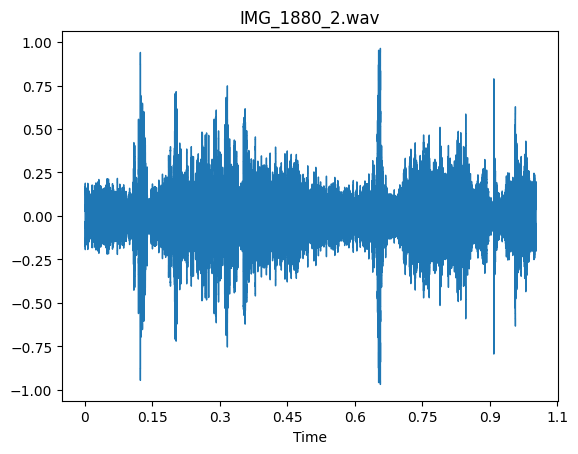

In [71]:

# Need show wave from audio array       

plt.subplots()
librosa.display.waveshow(audio, sr=sample_rate)
plt.title(file_name)


In [72]:
frameSize = 2048
hopSize = 512
stft_audio = librosa.stft(audio, n_fft = frameSize, hop_length = hopSize)
D_harmonic, D_percussive = librosa.decompose.hpss(stft_audio)

stft_audio_db = librosa.amplitude_to_db(np.abs(stft_audio), ref=np.max)
print(stft_audio.shape)

(1025, 87)


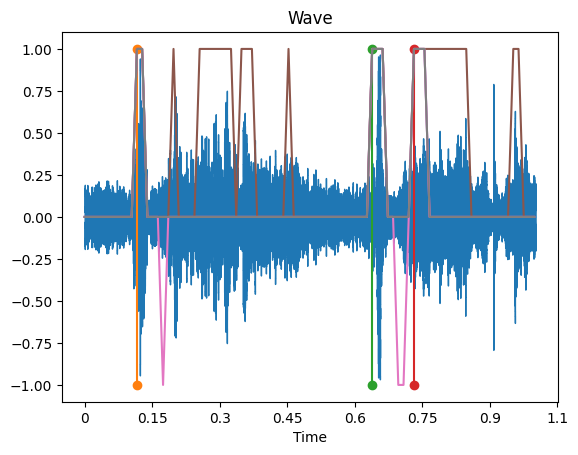

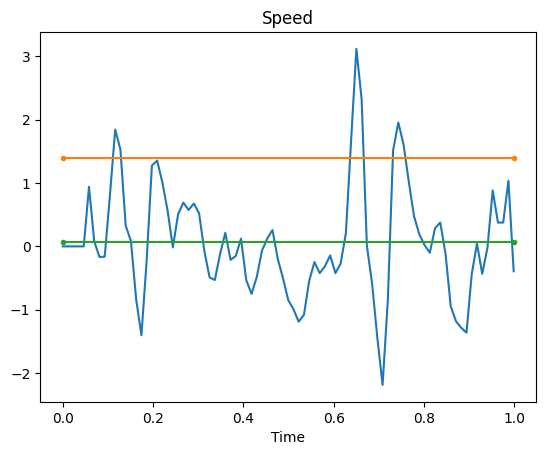

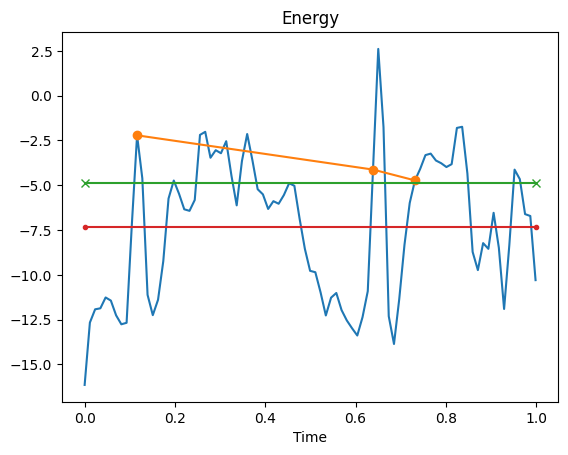

([0.11609977324263039, 0.6385487528344671, 0.7314285714285714],
 [-2.2139199, -4.125694, -4.729736])

In [75]:


get_auduo_jump_power(audio, sample_rate, show_chart=True)


(227.48734+28.657764j)


C:\Users\Nikolas\AppData\Local\Temp\ipykernel_19344\3658729663.py:12: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  librosa.display.specshow(librosa.power_to_db(stft_audio, ref=rp),sr=sample_rate, y_axis='log')
C:\Users\Nikolas\AppData\Local\Temp\ipykernel_19344\3658729663.py:17: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  librosa.display.specshow(librosa.power_to_db(D_harmonic, ref=rp), sr=sample_rate,y_axis='log')
C:\Users\Nikolas\AppData\Local\Temp\ipykernel_19344\3658729663.py:22: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  librosa.display.specshow(librosa.power_to_db(D_percussive, ref=rp),sr=sample_rate, y_axis='log', x_axis='time')


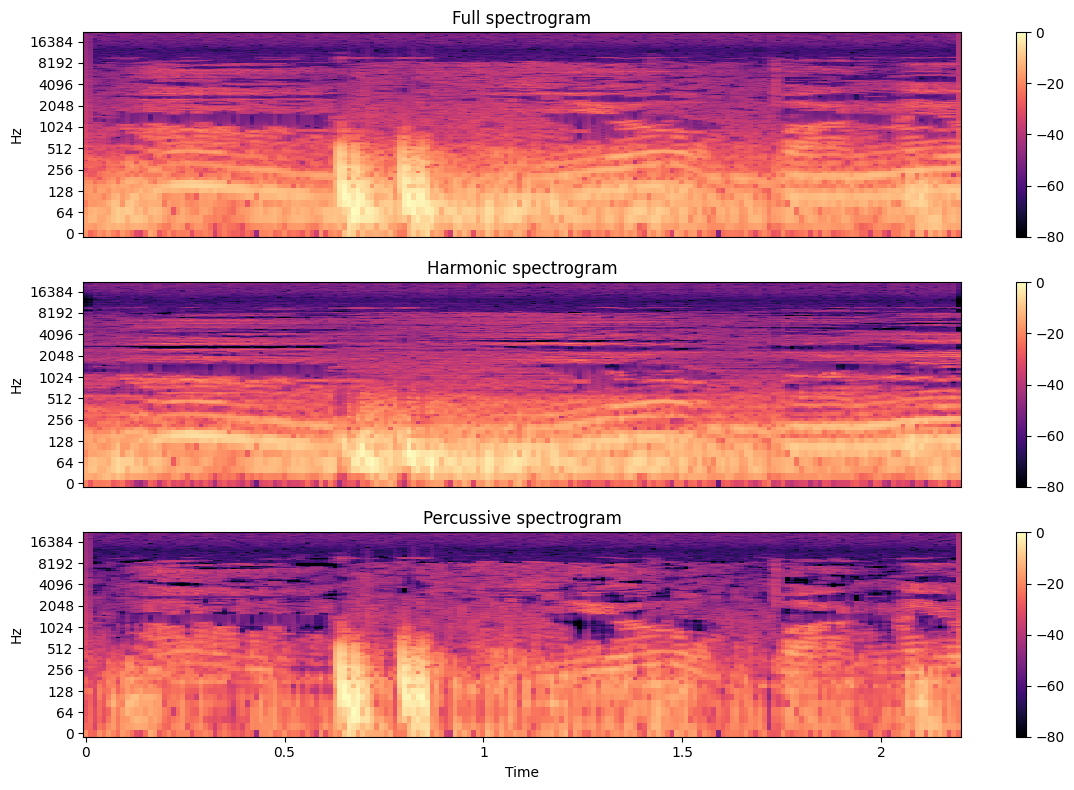

In [ ]:
stft_audio = librosa.stft(audio)#, n_fft = frameSize, hop_length = hopSize)
D_harmonic, D_percussive = librosa.decompose.hpss(stft_audio)

#rp = np.max(np.abs(stft_audio))
rp = np.max(stft_audio )
print(rp)
rp = np.max

plt.figure(figsize=(12, 8))

plt.subplot(3, 1, 1)
librosa.display.specshow(librosa.power_to_db(stft_audio, ref=rp),sr=sample_rate, y_axis='log')
plt.colorbar()
plt.title('Full spectrogram')

plt.subplot(3, 1, 2)
librosa.display.specshow(librosa.power_to_db(D_harmonic, ref=rp), sr=sample_rate,y_axis='log')
plt.colorbar()
plt.title('Harmonic spectrogram')

plt.subplot(3, 1, 3)
librosa.display.specshow(librosa.power_to_db(D_percussive, ref=rp),sr=sample_rate, y_axis='log', x_axis='time')
plt.colorbar()
plt.title('Percussive spectrogram')
plt.tight_layout()

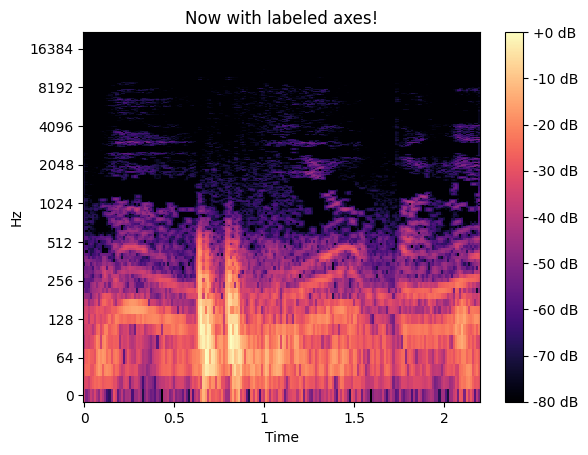

In [ ]:
fig, ax = plt.subplots()
img = librosa.display.specshow(stft_audio_db,sr=sample_rate, x_axis='time', y_axis='log', ax=ax)
ax.set(title='Now with labeled axes!')
fig.colorbar(img, ax=ax, format="%+2.f dB")


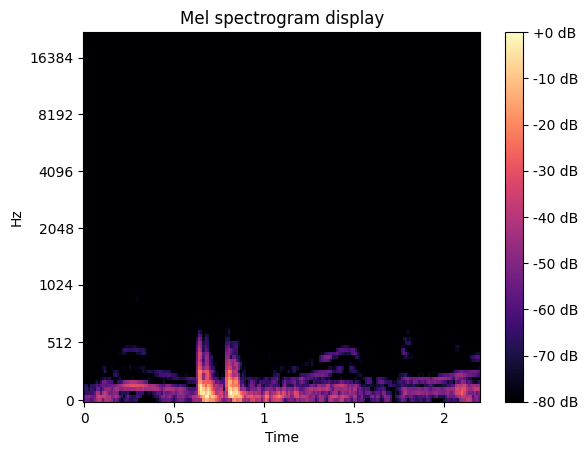

In [ ]:
fig, ax = plt.subplots()
M = librosa.feature.melspectrogram(y=audio, sr=sample_rate)
M_db = librosa.power_to_db(M, ref=np.max)
M_db = librosa.amplitude_to_db(M, ref=np.max)
img = librosa.display.specshow(M_db, y_axis='mel',sr=sample_rate, x_axis='time', ax=ax)
ax.set(title='Mel spectrogram display')
fig.colorbar(img, ax=ax, format="%+2.f dB")